In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import _spin_params as spin_pars
from importlib import reload
from _steady_state import a_steady, purcell
from _helper_functions import tsallis, cauchy, find_nearest, odeintz, find_nearest_sorted_left
from _create_pdf import create_spins, create_spins_inhomo_g
from _do_calculation import solve_mbes_general, solve_mbes, solve_mbes_without_cavity, get_pulses_from_cavity_field, solve_mbes_wait, solve_mbes_only_decay, solve_obes
from _mbes import mbes, mbes_soc, mbes_soc_no_cavity, mbes_soc_det, obes_soc
import matplotlib
# matplotlib.use('NbAgg')
import numpy as np
from scipy.stats import logistic
from scipy.optimize import basinhopping
from scipy.special import erf
from scipy import interpolate
from IPython.display import clear_output, Javascript, Markdown, HTML
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.io
import gc
#from qutip import Bloch
from matplotlib.animation import FuncAnimation
import datetime
import time
import random
import matplotlib
import _sys_helpers
# _sys_helpers.copy_connection_file()
# matplotlib.pyplot.switch_backend('nbagg')

In [2]:
gcoll = spin_pars.gcoll
q = spin_pars.q
quali = spin_pars.quali
fr = spin_pars.fr
kappa = np.pi*fr/quali  # HWHM
delta = spin_pars.delta  # detuning cavity to spin central frequency ws-wc
deltac = spin_pars.deltac  # detuning drive to cavity wc-wp
gperp = spin_pars.gperp  # HWHM
gpar = spin_pars.gpar  # 0.001 #HWHM
gammaq = spin_pars.gammaq
nbins = spin_pars.nbins  # 701#5000#20
g_number = spin_pars.g_number  # how many bins for inhomogeneous coupling
#g0 = gcoll/sqrt(nspins)
nreal = spin_pars.nreal
spin_dist_width = spin_pars.spin_dist_width
print(kappa)

7.14012477319922


In [3]:
def pulse_rwa(t, args):
    wgrund = args[0]
    fcomps = args[1]
    pulse = 0
    for i in range(len(fcomps)):
        pulse = pulse+(fcomps[i])*np.sin((i+1)*wgrund*t)
    return pulse


def pulse_rwa_gauss(t, args):
    wgrund = args[0]
    fcomps = args[1]
    nfcomps = len(fcomps)
    tend = np.pi/wgrund

    width = 2*tend/(nfcomps+5)
    t0 = 3*width/2
    pulse = 0
    for i in range(len(fcomps)):
        pulse += fcomps[i]*np.exp(-4*(t-t0)**2*np.log(2)/width**2)
        t0 += 0.5*width
    pulse *= logistic.cdf(t, loc=0.01, scale=.002) * \
        (1-logistic.cdf(t, loc=tend-0.01, scale=.002))
    pulse *= 0.46971947398573455
    return pulse


def pulse_rwa_gauss_const(t, args):
    wgrund = args[0]
    fcomps = args[1]
    maxampl = args[2]
    tend = np.pi/wgrund

    spline = 0
    for i in range(len(fcomps)):
        spline += (fcomps[i])*np.sin((i+1)*wgrund*t)
    pulsei = 0
    pulseq = 0
    pulse = 0
    pulse = maxampl*logistic.cdf(t, loc=0.02, scale=0.004) * \
        (1-logistic.cdf(t, loc=tend-0.02, scale=0.004))

    pulsei = pulse*np.cos(spline)
    pulseq = pulse*np.sin(spline)

    return pulsei, pulseq

In [4]:
def g_inhomo_function(x, sigma):
    return np.exp(-x**2/sigma**2)


x_start = 5
x_stop = 20  # µm
x = np.linspace(x_start, x_stop, g_number)
sigma = 5
g_temp = g_inhomo_function(x, sigma)
g_list = g_temp/np.sum(g_temp)

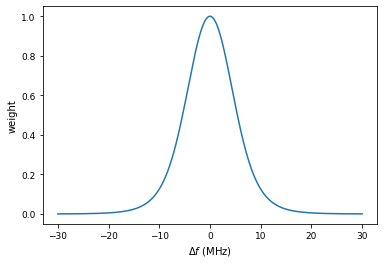

Cooperativity is: 4.403801


In [5]:
plt.close('all')
matplotlib.interactive(False)
spins, gs, pdf = create_spins_inhomo_g(
    gcoll, g_list, q, delta, gammaq, nbins, holes=False, inhomo=True, hyperfine=True, spin_width=spin_dist_width)
plt.figure()
plt.plot(spins[:len(pdf)], pdf/max(pdf))
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('weight')
plt.show()
# %qtconsole
coop = gcoll**2/kappa*np.sum(pdf/(gperp+1j*2*np.pi*spins))
print("Cooperativity is: %f" % coop.real)
# %qtconsole

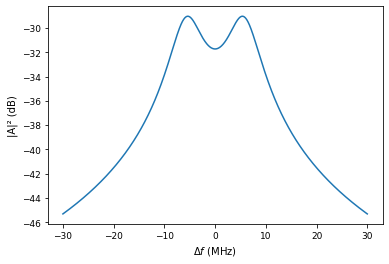

In [6]:
plt.close('all')
matplotlib.interactive(False)

initsteady = (0.001, 0.001)
fstart = 30
deltaarr = np.linspace(-fstart*2*np.pi, fstart*2*np.pi, 2000)
etasteady = 0.00001
losasteady = np.zeros(np.shape(deltaarr))
losareal = np.zeros(np.shape(deltaarr))
losaimag = np.zeros(np.shape(deltaarr))

newinit = initsteady
for i, delt in enumerate(deltaarr):
    ar, ai = a_steady(etasteady, delt, gs, spins, gpar, gperp, kappa, newinit)
    newinit = (ar, ai)
    losasteady[i] = ai**2+ar**2
    losareal[i] = ar
    losaimag[i] = ai

fig = plt.figure()
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('|A|² (dB)')
plt.plot(deltaarr/2/np.pi, 10*np.log10(losasteady/0.0000000001))
plt.show()
# %qtconsole
#deltaarr[find(losasteady == max(losasteady))]/2/pi

# SOC pulses

In [7]:
pumptime = 50e-3  # 5*np.pi/gcoll
decaytime = 1000e-3
dt = 0.0005
numsteps = int(pumptime/dt)
tlist = np.arange(0, pumptime+dt, dt)
tlistdecay = np.arange(0, decaytime+dt, dt)


# test time it takes to calculate


init = np.ones(len(spins)*2+1)*(-1)
init[0] = 0
init[1:len(spins)+1] = 0
# %qtconsole

### Calibrate power

In [8]:
pulsei = np.ones((len(tlist)))
pin = np.arange(-25,
                -5, 1)
aref = 1800

alos = np.zeros((len(pin), len(tlist)+len(tlistdecay)))
szlos = np.zeros(np.shape(alos))
szall = np.zeros((len(pin), len(tlist)+len(tlistdecay), nbins))
small = np.zeros(np.shape(szall))
smlos = np.zeros(np.shape(alos))

for ctr, p in enumerate(pin):
    dr = aref*10**(p/20.)
    asolpump, asoldecay, infodict = solve_mbes(
        mbes, init, pdf, tlist, tlistdecay, dr, kappa, deltac, np.asarray(gs, dtype=np.complex128), gperp, spins, gpar)
    alos[ctr, :] = np.hstack((abs(asolpump[:, 0])**2, abs(asoldecay[:, 0])**2))
    szlos[ctr, :] = np.hstack((np.real(np.sum(asolpump[:, 2::2], axis=1)), np.real(
        np.sum(asoldecay[:, 2::2], axis=1))))
    szall[ctr, :, :] = np.vstack(
        (np.real(asolpump[:, 2::2]), np.real(asoldecay[:, 2::2])))
    small[ctr, :, :] = np.vstack(
        (np.real(asolpump[:, 1::2]), np.real(asoldecay[:, 1::2])))
    smlos[ctr, :] = np.hstack((np.real(np.sum(asolpump[:, 1::2], axis=1)), np.real(
        np.sum(asoldecay[:, 1::2], axis=1))))
# %qtconsole

-8


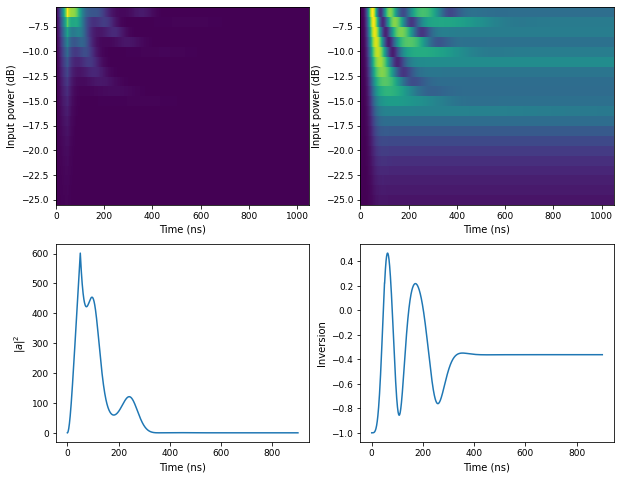

In [9]:
plt.close('all')
matplotlib.interactive(False)
tplot = np.linspace(0, 1000*(pumptime+decaytime), len(tlist)+len(tlistdecay))
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
#fig.set_size_inches([12, 8])
ax1.pcolor(tplot, pin, alos)
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Input power (dB)')

ax2.pcolor(tplot, pin, szlos)
ax2.set_xlabel('Time (ns)')
ax2.set_ylabel('Input power (dB)')
maxAmpl = abs(asolpump).max()

idxinv = 17
print(pin[idxinv])
ax3.plot(tplot[:-300], alos[idxinv, :-300])
#ax3.set_ylim([0, 1])
ax3.set_xlabel('Time (ns)')
ax3.set_ylabel('$|a|^2$')
ax4.plot(tplot[:-300], szlos[idxinv, :-300])
ax4.set_xlabel('Time (ns)')
ax4.set_ylabel('Inversion')
plt.show()
# %qtconsole

### Chirp pulses

In [10]:
def pulse_chirped(t, args, ichannel=True):
    tau = args[0]
    tend = args[1]
    t0 = tend/2
    alpha = args[2]
    if ichannel:
        return np.cos(np.abs(t-t0)**2*alpha)*np.exp(-(t-t0)**2/(2*tau**2))
    else:
        return np.sin(np.abs(t-t0)**2*alpha)*np.exp(-(t-t0)**2/(2*tau**2))


def pulse_chirped_erf(t, args, ichannel=True):
    tau = args[0]
    tend = args[1]
    t0 = tend/2
    alpha = args[2]

    envelope = 0.25*(1+erf(tau*(t-tau*0.0005))) * \
        (erfc(tau*(t-tend + tau*0.0005)))
    if ichannel:
        return np.cos(np.abs(t-t0)**2*alpha)*envelope
    else:
        return np.sin(np.abs(t-t0)**2*alpha)*envelope

In [11]:
tend = 400e-3
tp = np.arange(0, tend+dt, dt)
tplot2 = np.linspace(0, 1000*(pumptime+decaytime), len(tp)+len(tlistdecay))


dtf = 0.0001
tpf = np.arange(0, tend+dtf, dtf)
tau = tend*0.1625
alpha = -10*gammaq/tend/2  # sweeps from -8 linewidth to 8* linewidth

# %qtconsole
pulsei = pulse_chirped(tp, (tau, tend, alpha), True)
pulseq = pulse_chirped(tp, (tau, tend, alpha), False)

pulseif = pulse_chirped(tpf, (tau, tend, alpha), True)
pulseqf = pulse_chirped(tpf, (tau, tend, alpha), False)


obes_pulse_scaling = 90


init = np.zeros(len(spins)*2)
init[len(spins):] = -1
solpump_obes, infodict = solve_obes(
    obes_soc, init, pdf, tp, None, obes_pulse_scaling*pulsei, obes_pulse_scaling*pulseq, tp, 1, gperp, spins, gpar)

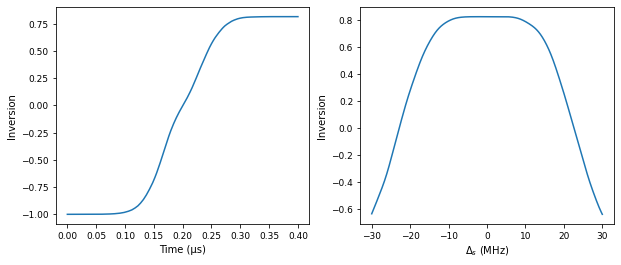

In [12]:
plt.close('all')
matplotlib.interactive(False)

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(tp, np.sum(np.real(solpump_obes[:, 1::2]), axis=1))
ax1.set_xlabel('Time (µs)')
ax1.set_ylabel('Inversion')
ax2.plot(spins, np.real(solpump_obes[-1, 1::2]/pdf))
ax2.set_xlabel('$\Delta_s$ (MHz)')
ax2.set_ylabel('Inversion')
plt.show()

In [13]:
init = np.ones(nbins*2)*(-1)
init[:nbins] = 0

amplitude_scaling = 1/gs[int(nbins/2)]/2*obes_pulse_scaling


solutionpump, infodict = solve_mbes_without_cavity(
    mbes_soc_no_cavity, init, pdf, tp, None, pulsei*amplitude_scaling, amplitude_scaling*pulseq, tp, deltac, gs, gperp, spins, gpar)
ipulse, qpulse = get_pulses_from_cavity_field(
    amplitude_scaling*(pulsei + 1j*pulseq), amplitude_scaling*(pulseif+1j*pulseqf), solutionpump[:, ::2]/pdf, tp, tpf, kappa, deltac, gs)

init = np.ones(nbins*g_number*2+1)*(-1)
init[0] = 0
init[1:nbins+1] = 0

solutionpump_perfect, soldecay_perfect, infodict = solve_mbes(
    mbes_soc, init, pdf, tp, tlistdecay, ipulse, qpulse, tp, kappa, deltac, gs, gperp, spins, gpar)

In [14]:
maxp = max(max(abs(ipulse)), max(abs(qpulse)))
ipulsen = ipulse/maxp
qpulsen = qpulse/maxp
pin_chirp = np.arange(-15, 10, 1)


init = np.ones(nbins*g_number*2+1)*(-1)
init[0] = 0
init[1:nbins+1] = 0
solutionp_chirp = np.ones(
    (len(pin_chirp), len(tp), 2*nbins+1), dtype=np.complex128)
solutiond_chirp = np.ones(
    (len(pin_chirp), len(tlistdecay), 2*nbins+1), dtype=np.complex128)

for ctr, p in enumerate(pin_chirp):
    print("Checking power %d from %d" % (ctr+1, len(pin_chirp)), end="\r")
    dr = aref*10**(p/20.)
    solutionpump, soldecay, infodict = solve_mbes(
        mbes_soc, init, pdf, tp, tlistdecay, ipulsen*dr, qpulsen*dr, tp, kappa, deltac, gs, gperp, spins, gpar)
    solutionp_chirp[ctr, :, :] = solutionpump
    solutiond_chirp[ctr, :, :] = soldecay

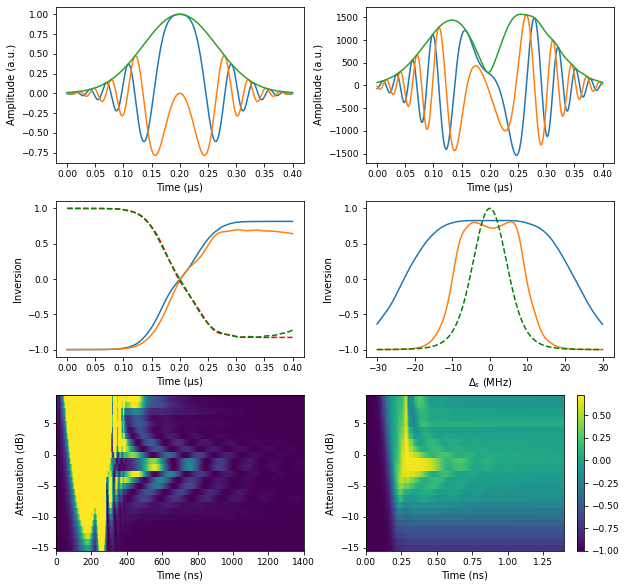

In [15]:
# %qtconsole
plt.close('all')
matplotlib.interactive(False)
# print(ascalelist[idealidx])
fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5)
      ) = plt.subplots(3, 2, figsize=(10, 10))

ax0.plot(tpf, pulseif)
ax0.plot(tpf, pulseqf)
ax0.plot(tpf, np.sqrt(pulseif**2+pulseqf**2))

ax0.set_xlabel("Time (µs)")
ax0.set_ylabel("Amplitude (a.u.)")

ax1.plot(tp, ipulse)
ax1.plot(tp, qpulse)
ax1.plot(tp, (ipulse**2+qpulse**2)**0.5)
#ax1.plot(tp, (pulselist[idealidx][0]**2+pulselist[idealidx][1]**2)**0.5)
ax1.set_xlabel("Time (µs)")
ax1.set_ylabel("Amplitude (a.u.)")

d = np.real(solpump_obes[:, 1::2])
d2 = np.real(solutionpump_perfect[:, 2::2])
ax2.plot(tp, np.sum(d, axis=1))
ax2.plot(tp, np.sum(d2, axis=1))
ax2.plot(tp, -1*d[:, int(nbins/2)]/pdf[int(nbins/2)], 'r--')
ax2.plot(tp, -1*d2[:, int(nbins/2)]/pdf[int(nbins/2)], 'g--')

ax2.set_xlabel('Time (µs)')
ax2.set_ylabel('Inversion')


ax3.plot(spins, d[-1]/pdf)
ax3.set_xlabel('$\Delta_s$ (MHz)')
ax3.set_ylabel('Inversion')
ax3.plot(spins, np.real(d2[-1]/pdf))
ax3.plot(spins, 2*pdf/max(pdf)-1, 'g--')
ax3.set_xlabel('$\Delta_s$ (MHz)')
ax3.set_ylabel('Inversion')

tall = np.linspace(0, tp[-1]+tlistdecay[-1],
                   len(tp)+len(tlistdecay))

szlos_chirp = np.hstack((np.real(np.sum(solutionp_chirp[:, :, 2::2], axis=2)), np.real(
    np.sum(solutiond_chirp[:, :, 2::2], axis=2))))
alos_chirp = np.hstack(
    (solutionp_chirp[:, :, 0], solutiond_chirp[:, :, 0]))

ax4.pcolor(tall*1000, pin_chirp, np.abs(alos_chirp)**2, vmax=40)
ax4.set_xlabel('Time (ns)')
ax4.set_ylabel('Attenuation (dB)')

c = ax5.pcolor(tall, pin_chirp, szlos_chirp)
ax5.set_xlabel('Time (ns)')
ax5.set_ylabel('Attenuation (dB)')
fig.colorbar(c, ax=ax5)
plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.show()
# %qtconsole

In [17]:
%matplotlib widget
plt.close('all')
matplotlib.interactive(False)


szlos_oct_animate = (solutionpump_perfect[:, 2::2])/pdf
smlos_oct_animate = (solutionpump_perfect[:, 1::2])/pdf


def middle_out(a):
    while a:
        yield a.pop(len(a) // 2)


stepsize = 9
idxs = np.arange(int(nbins/2)-10*stepsize, int(nbins/2)+11*stepsize, stepsize)
spins_plot = spins[idxs]
idxs = np.asarray(list(middle_out(list(idxs))))[::-1]
cmap = cm.get_cmap("brg")
norm = matplotlib.colors.Normalize(vmin=min(spins_plot), vmax=max(spins_plot))
colors_idx = (spins[idxs]-min(spins[idxs]))/(max(spins[idxs])-min(spins[idxs]))
colors = cmap(colors_idx)

weights = pdf[idxs]
weights *= 1/max(weights)

sz_animate = szlos_oct_animate[:, idxs].real
sx_animate = smlos_oct_animate[:, idxs].real
sy_animate = smlos_oct_animate[:, idxs].imag
lenframes = len(sz_animate[:, 0])

vecs = np.zeros((*np.shape(sz_animate), 3))
vecs[:, :, 0] = sx_animate
vecs[:, :, 1] = sy_animate
vecs[:, :, 2] = sz_animate

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(5, 5))

ax = fig.add_subplot(1, 1, 1, projection='3d')

cb1 = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, shrink=0.7)
cb1.set_label('Detuning (MHz)')
b = Bloch(axes=ax)
b.fig = fig


def init():
    b.clear()
    b.zlabel = ['$\\left|1\\right>$', '$\\left|0\\right>$']
    b.font_size = 15
    b.vector_color = colors
    b.point_size = [1]
    b.point_color = [cmap(0.5)]
    return ax


def animate(frame_num):
    b.clear()
    b.add_vectors(vecs[frame_num, :, :])
    b.add_points([vecs[:frame_num+1, -1, 0],
                 vecs[:frame_num+1, -1, 1], vecs[:frame_num+1, -1, 2]])
    b.make_sphere()
    return ax


anim = matplotlib.animation.FuncAnimation(fig, animate, init_func=init,
                                          frames=lenframes, interval=1,
                                          blit=False, repeat=False)


gc.collect()
plt.show()
%matplotlib inline

ModuleNotFoundError: No module named 'ipympl'

In [ ]:
fn = "/mnt/samba0/angerer/WENZEL/pulse_chirped_3_cooldown33.mat"

In [16]:
scipy.io.savemat("/home/andreas/new_pulse.mat",
                 {"pulse": np.hstack((ipulsen, qpulsen))})

In [ ]:
data = scipy.io.loadmat(fn, simplify_cells=True)

In [ ]:
right_side = -np.arctan(10000*(tlist-tlist[-6]))+np.pi/2
left_side = np.arctan(10000*(tlist-tlist[5]))+np.pi/2
rect_pulse = right_side*left_side/np.pi/np.pi

spinslp, gslp, pdflp = create_spins_inhomo_g(
    28.217785214543518, g_list, 1.235, 0.009 * 2*pi, 10.361 * 2*pi, nbins, holes=False, inhomo=True, hyperfine=True)

dr = 695.5942/1.4
# solutionpumplp, soldecaylp, infodict = solve_mbes(
#    mbes_soc, init, pdflp, tp, tlistdecay, ipulsen*dr, qpulsen*dr, tp, kappa, deltac, gslp, gperp, spinslp, gpar)
solutionpumplp, soldecaylp, infodict = solve_mbes(
    mbes_soc, init, pdflp, tp, tlistdecay, data['pulse'][0]*dr, data['pulse'][1]*dr, tp, 0.839 * 2*pi, 0, gslp, 0.3*2*np.pi, spinslp, gpar)
a2lp = np.hstack((solutionpumplp[:, 0],  soldecaylp[:, 0]))

In [ ]:
dat = np.asarray([1*data["meas_run"][i]["IQdata"][:, 0]**2+1*data["meas_run"]
                  [i]["IQdata"][:, 1]**2 for i in range(len(data["meas_run"]))])[:, 2010:3900]
scan_vals = data['scan_values'][:len(dat)]

In [ ]:
idx = 1
dat2 = dat[idx]
print(scan_vals[idx])
tdata = np.arange(0, len(dat2)*0.5e-9, 0.5e-9)*1e9
#plt.plot(tdata, dat2**0.5)
idx2 = 6
plt.plot(tall, np.abs(a2lp)/7)
plt.show()

In [ ]:
plt.show()

In [ ]:
plt.pcolor(tdata, -scan_vals, dat**0.5)
plt.show()

In [ ]:
alos.shape